In [1]:
import numpy as np
import pandas as pd
import sklearn 
import imblearn 
from sklearn.metrics import classification_report, confusion_matrix
import math 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
german_data = pd.read_csv('german_data.csv')
print(german_data)

     stat_check_acc  duration_month  credit_history  purpose  credit_amount  \
0                 1               6               5        4           1169   
1                 2              48               3        4           5951   
2                 4              12               5        7           2096   
3                 1              42               3        3           7882   
4                 1              24               4        1           4870   
..              ...             ...             ...      ...            ...   
995               4              12               3        3           1736   
996               1              30               3        2           3857   
997               4              12               3        4            804   
998               1              45               3        4           1845   
999               2              45               5        2           4576   

     Age Group  savings_bonds  employment_since  in

In [3]:
### set sensitive attribute equal to 'SEX' or 'Age Group' ###

sen_att= 'Age Group'

In [4]:
#split data in a test and train set

from sklearn.model_selection import train_test_split
X = german_data.loc[:, german_data.columns != 'approval']
y = german_data.loc[:, german_data.columns == 'approval']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

#apply SMOTE to the trainingset
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['approval'])



In [5]:
os_data_X.shape

(1120, 19)

In [6]:
print(os_data_X)

      stat_check_acc  duration_month  credit_history  purpose  credit_amount  \
0                  2              24               3        1           1246   
1                  1              12               3        1            900   
2                  4               6               3        1            672   
3                  4              10               3        2           2848   
4                  4              48               5       10           7629   
...              ...             ...             ...      ...            ...   
1115               1              24               2        4           3222   
1116               2              33               3        1          12455   
1117               1              20               2        6           3177   
1118               1              12               3        6            684   
1119               1              32               3        2           3454   

      Age Group  savings_bonds  employm

In [7]:
# we can Check the numbers of our data
print("length oversampled data: ",len(os_data_X))
print ("check for class values: ",len(os_data_y))
print("Nr no approval",len(os_data_y[os_data_y['approval']==0]))
print("Number of approval",len(os_data_y[os_data_y['approval']==1]))
print("Proportion no approval ",len(os_data_y[os_data_y['approval']==0])/len(os_data_X))
print("Proportion of approval s ",len(os_data_y[os_data_y['approval']==1])/len(os_data_X))

length oversampled data:  1120
check for class values:  1120
Nr no approval 560
Number of approval 560
Proportion no approval  0.5
Proportion of approval s  0.5


In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier as a ranker 
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(os_data_X, os_data_y)

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
y_pred = knn.predict(os_data_X)


from sklearn.metrics import classification_report
print(classification_report(os_data_y, y_pred))




              precision    recall  f1-score   support

           0       0.64      0.77      0.70       560
           1       0.72      0.57      0.64       560

    accuracy                           0.67      1120
   macro avg       0.68      0.67      0.67      1120
weighted avg       0.68      0.67      0.67      1120



<ipython-input-8-cb4c76803ffd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(os_data_X, os_data_y)


In [9]:
matrix = sklearn.metrics.confusion_matrix(os_data_y, y_pred)
sklearn.metrics.accuracy_score(os_data_y, y_pred)
print(matrix)

[[433 127]
 [239 321]]


In [10]:
### append the ranker results to the dataset ####

result = pd.concat([os_data_X, os_data_y.reindex(os_data_X.index)], axis=1)
prob  = knn.predict_proba(os_data_X)[:,1]


result['prob'] = prob
print(result)
#df_test = [os_data_X, os_data_y, df_prob]


      stat_check_acc  duration_month  credit_history  purpose  credit_amount  \
0                  2              24               3        1           1246   
1                  1              12               3        1            900   
2                  4               6               3        1            672   
3                  4              10               3        2           2848   
4                  4              48               5       10           7629   
...              ...             ...             ...      ...            ...   
1115               1              24               2        4           3222   
1116               2              33               3        1          12455   
1117               1              20               2        6           3177   
1118               1              12               3        6            684   
1119               1              32               3        2           3454   

      Age Group  savings_bonds  employm

In [11]:
## building the discrimination formula: 

def disc(df, S, y, sv, nv):
    sum_sen_neg = 0
    sum_sen_pos = 0
    sum_non_neg = 0
    sum_non_pos = 0

    for row in range(len(df)) :
        if df.at[row, S] == sv and df.at[row, y] == 0:
            sum_sen_neg +=1
        elif df.at[row, S] == sv and df.at[row, y] == 1: 
            sum_sen_pos += 1
        elif df.at[row, S] == nv and df.at[row, y] == 0: 
            sum_non_neg += 1
        else:
            sum_non_pos += 1
        #print(sum_non_neg, sum_non_pos)
    
    sum_sen = sum_sen_neg + sum_sen_pos
    sum_non = sum_non_neg + sum_non_pos
    
    disc_val = (abs(sum_non_pos/sum_non)-abs(sum_sen_pos/sum_sen)) 
    print(sum_non_pos/sum_non)
    print(sum_sen_pos/sum_sen)
    print("women neg",sum_sen_neg,"women pos", sum_sen_pos, "men neg", sum_non_neg,  "men pos",sum_non_pos)
    return disc_val

#TEST
disc(result, sen_att, 'approval', 0, 1)


0.6923076923076923
0.48031496062992124
women neg 528 women pos 488 men neg 32 men pos 72


0.21199273167777105

In [12]:
#sensitive value counts 

def count_s_val(df, S, v):
    count = 0
    for row in range(len(df)):
        if df.at[row, S] == v: 
            count += 1
        else:
            pass
    return count 

men_count = count_s_val(result, sen_att, 0)    
print ('Men count',men_count)

#define size of values for massaging M

M = math.ceil(((disc(result, sen_att, 'approval', 0, 1)) * (count_s_val(result, "approval", 0)) *  (count_s_val(result, "approval", 1)))/((count_s_val(result, "approval", 0)) +  (count_s_val(result, "approval", 1))))
print(M)

Men count 1016
0.6923076923076923
0.48031496062992124
women neg 528 women pos 488 men neg 32 men pos 72
60


In [13]:
# organise the results in descending order 
result_sorted = result.sort_values(by=[sen_att, 'prob'], ascending=[True, False], ignore_index=True)
result_sorted

,stat_check_acc,duration_month,credit_history,purpose,credit_amount,Age Group,savings_bonds,employment_since,installment_in_percent,sex,...,residence_since,property,other_installment_plans,housing,nr_credits,job,nr_dependants,phone,approval,prob
0,2,12,1,9,1410,0,1,3,2,0,...,2,1,3,2,1,2,1,2,1,1.000000
1,2,14,3,10,1410,0,3,5,1,0,...,2,1,3,2,1,3,1,2,1,1.000000
2,1,15,3,1,1403,0,1,3,2,1,...,4,3,3,1,1,3,1,1,1,1.000000
3,4,12,5,10,1412,0,1,3,4,1,...,2,1,3,2,2,4,1,2,1,1.000000
4,4,24,3,4,1413,0,1,3,4,0,...,2,2,3,2,1,3,1,1,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,2,54,1,10,15779,1,1,2,3,0,...,4,4,2,1,1,3,1,2,0,0.266667
1116,2,57,1,10,15307,1,1,3,3,0,...,4,4,1,2,1,3,1,2,0,0.266667
1117,2,48,4,7,6224,1,1,5,4,0,...,4,4,3,3,1,3,1,1,0,0.200000
1118,2,27,3,7,2723,1,2,4,4,0,...,2,3,1,1,1,2,1,1,0,0.200000


In [14]:
### applying massaging for the minorty class to transform to a positive output 

i = 0
for row in range(len(result_sorted)):
    
    if i <= M and result_sorted.at[row, sen_att] == 0 and result_sorted.at[row, "approval"] == 0:
        result_sorted.at[row, 'approval'] = 1 
        i += 1
    else:
        pass 
print (i)

print (result_sorted)

61
      stat_check_acc  duration_month  credit_history  purpose  credit_amount  \
0                  2              12               1        9           1410   
1                  2              14               3       10           1410   
2                  1              15               3        1           1403   
3                  4              12               5       10           1412   
4                  4              24               3        4           1413   
...              ...             ...             ...      ...            ...   
1115               2              54               1       10          15779   
1116               2              57               1       10          15307   
1117               2              48               4        7           6224   
1118               2              27               3        7           2723   
1119               4              60               5        1          13756   

      Age Group  savings_bonds  empl

In [15]:
## resorting the dataset to change the unportected group to a negative classification


result_sorted_2 = result_sorted.sort_values(by=[sen_att, 'prob'], ascending=[False, True], ignore_index=True)
print(result_sorted_2)

      stat_check_acc  duration_month  credit_history  purpose  credit_amount  \
0                  4              60               5        1          13756   
1                  2              48               4        7           6224   
2                  2              27               3        7           2723   
3                  1               6               3        1          14896   
4                  4              12               5        1            682   
...              ...             ...             ...      ...            ...   
1115               1              15               3        1           1403   
1116               4              12               5       10           1412   
1117               4              24               3        4           1413   
1118               2               8               3        4           1414   
1119               4              24               5        4           2872   

      Age Group  savings_bonds  employm

In [16]:
## sorting to create negative values for the unprotected group

i = 0
for row in range(len(result_sorted_2)):
    
    if i <= M and result_sorted_2.at[row, sen_att] == 1 and result_sorted_2.at[row, "approval"] == 1:
        result_sorted_2.at[row, 'approval'] = 0 
        i += 1
    else:
        pass 
print (i)

print (result_sorted_2)

61
      stat_check_acc  duration_month  credit_history  purpose  credit_amount  \
0                  4              60               5        1          13756   
1                  2              48               4        7           6224   
2                  2              27               3        7           2723   
3                  1               6               3        1          14896   
4                  4              12               5        1            682   
...              ...             ...             ...      ...            ...   
1115               1              15               3        1           1403   
1116               4              12               5       10           1412   
1117               4              24               3        4           1413   
1118               2               8               3        4           1414   
1119               4              24               5        4           2872   

      Age Group  savings_bonds  empl

### visualisations of what happens to the data

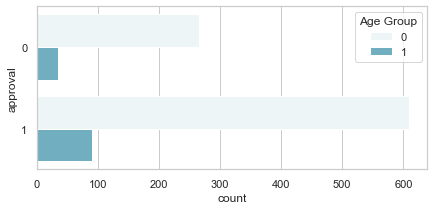

In [17]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='approval', hue =sen_att, data=german_data, color="c")

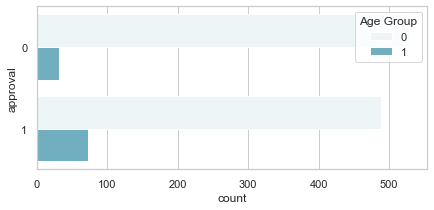

In [18]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='approval', hue =sen_att, data=result, color="c")

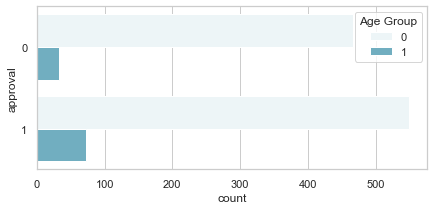

In [19]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='approval', hue =sen_att, data=result_sorted, color="c")

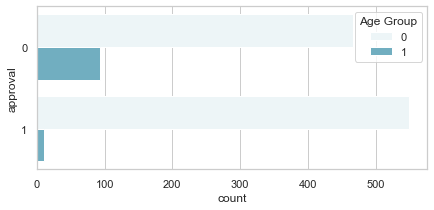

In [20]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='approval', hue =sen_att, data=result_sorted_2, color="c")

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler


X_train = result_sorted_2.loc[:, result_sorted_2.columns != 'approval']
y_train = result_sorted_2.loc[:, result_sorted_2.columns =='approval']

del X_train["prob"]

y_train =y_train.to_numpy()

y_train = y_train.ravel()

logit = LogisticRegression(penalty='l2', solver = 'liblinear', max_iter = 5000)
#logit = LogisticRegression()
logit.fit(X_train, y_train)


X_test.shape

(200, 19)

In [22]:

y_pred =  logit.predict(X_test)


from sklearn.metrics import classification_report


matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(matrix)

[[ 33  27]
 [ 38 102]]


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.55      0.50        60
           1       0.79      0.73      0.76       140

    accuracy                           0.68       200
   macro avg       0.63      0.64      0.63       200
weighted avg       0.69      0.68      0.68       200



In [24]:
privileged_groups = [{sen_att: 0}]
unprivileged_groups = [{sen_att: 1}]


In [25]:
fair_test_df = pd.concat([X_test, y_test], axis=1, join="inner")

In [26]:
# Metrics function
from collections import OrderedDict
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(fair_test_df, 
                          label_name='approval', 
                          favorable_classes=[1], 
                          protected_attribute_names=[sen_att], 
                          privileged_classes=[[0]])

def fair_metrics(dataset, y_pred, disp = True):
    dataset_pred =dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric_pred = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
        
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))


fair_metrics(dataset, y_pred)

Balanced accuracy = 0.6393
Statistical parity difference = -0.6856
Disparate impact = 0.0573
Average odds difference = -0.6365
Equal opportunity difference = -0.7821
Theil index = 0.2546
